In [1]:
from fenics import *
from mshr import *

In [2]:
# Read mesh from file
# rectangle = Rectangle(Point(0, 0), Point(5.0, 1.0))
# mesh = generate_mesh(rectangle, 50)
mesh = UnitSquareMesh(50, 50)

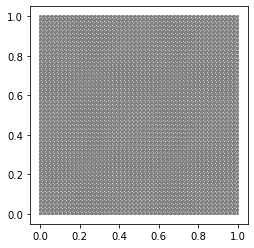

In [3]:
plot(mesh)

In [4]:
# Define function space for system of concentrations
P1 = FiniteElement("P", triangle, 1)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

In [5]:
# Define test functions
v_1, v_2, v_3 = TestFunctions(V)

In [6]:
# Define functions for f amd g
u = Function(V)

# Split system functions to access components
f, g, h = split(u)

In [7]:
# Define boundaries
top     = 'near(x[1], 1.0)'
right   = 'near(x[0], 1.0)'
bottom  = 'near(x[1], 0.0)'
left    = 'near(x[0], 0.0)'

# Define boundary conditions
"""
top: x^2 + x
right: y^2 + y
bottom: 0
left: 0
"""
bc_f_top    = DirichletBC(V.sub(0), Expression("pow(x[0], 2)+x[0]", degree=2), top)
bc_f_right  = DirichletBC(V.sub(0), Expression("pow(x[1], 2)+x[1]", degree=2), right)
bc_f_bottom = DirichletBC(V.sub(0), Constant(0.0), bottom)
bc_f_left   = DirichletBC(V.sub(0), Constant(0.0), left)

"""
top: x^3 + 1
right: y^2 + 1
bottom: x^3
left: y^2
"""
bc_g_top    = DirichletBC(V.sub(1), Expression("pow(x[0], 3)+1", degree=3), top)
bc_g_right  = DirichletBC(V.sub(1), Expression("pow(x[1], 2)+1", degree=1), right)
bc_g_bottom = DirichletBC(V.sub(1), Expression("pow(x[0], 3)", degree=3), bottom)
bc_g_left   = DirichletBC(V.sub(1), Expression("pow(x[1], 2)", degree=2), left)

"""
top: -x^2 + 1
right: y^3 - 1
bottom: -x^2
left: y^3
"""

bc_h_top    = DirichletBC(V.sub(2), Expression("1-pow(x[0], 2)", degree=2), top)
bc_h_right  = DirichletBC(V.sub(2), Expression("pow(x[1], 3)-1", degree=3), right)
bc_h_bottom = DirichletBC(V.sub(2), Expression("-pow(x[0], 2)", degree=2), bottom)
bc_h_left   = DirichletBC(V.sub(2), Expression("pow(x[1], 3)", degree=3), left)

# bc_f = [bc_f_top, bc_f_bottom, bc_f_right, bc_f_left]
# bc_g = [bc_g_top, bc_g_bottom, bc_g_right, bc_g_left]
bc_array = [bc_f_top, bc_f_bottom, bc_f_right, bc_f_left, bc_g_top, bc_g_bottom, bc_g_right, bc_g_left, \
            bc_h_top, bc_h_bottom, bc_h_right, bc_h_left]


In [8]:
# Define source terms
# 2x^2 + y^2 - x^3 + x^2* y^5 + x * y^4 - x^4 * y^2 - x^3 * y
s_1 = Expression("2*pow(x[0], 2) + pow(x[1], 2)- pow(x[0], 3)" + 
                 "+ pow(x[0], 2) * pow(x[1], 5)+ pow(x[0], 1) * pow(x[1], 4)" +\
                 "- pow(x[0], 4)*pow(x[1], 2) - pow(x[0], 3) * x[1]", degree=7)

# 6x + 2 - x^2 * y^2 - x*y - y^3 + x^2
s_2 = Expression("6*x[0] + 2 - pow(x[0],2)*pow(x[1],2) - x[0]*x[1]" +\
                 "- pow(x[1],3) + pow(x[0],2)", degree=4)

# 6y - 2 - x^5*y^2 - x^4*y - x^2*y^4 - x* y^3
s_3 = Expression("6*x[1] - 2 - pow(x[0],5)*pow(x[1], 2) - pow(x[0], 4)*x[1]" +\
                 "- pow(x[0],2)*pow(x[1],4) - x[0]*pow(x[1],3)", degree=7)

In [9]:
# Define variational problem
F = dot(grad(v_1), grad(f)) * dx + dot(grad(v_2), grad(g)) * dx \
    + dot(grad(v_3), grad(h)) * dx + v_1 * (g - h* f + s_1) * dx \
    + v_2 * (f + h + s_2) * dx + v_3 * (f * g + s_3) * dx

In [10]:
list_krylov_solver_preconditioners()

In [11]:
J = derivative(F, u)
problem = NonlinearVariationalProblem(F, u, bc_array, J )
solver  = NonlinearVariationalSolver(problem)
prm = solver.parameters

prm["nonlinear_solver"]="newton"
prm["newton_solver"]["linear_solver"] = "lu"
prm['newton_solver']['maximum_iterations'] = 100
prm['newton_solver']['relaxation_parameter'] = 0.5


# prm['maximum_iterations'] = 100
solver.solve()


(30, True)

In [22]:
#solve(F==0, u, bc_array)

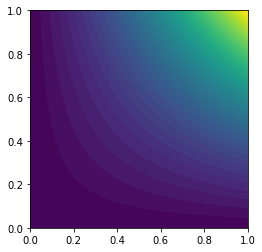

In [11]:
plot(f)

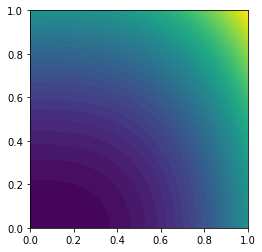

In [12]:
plot(g)

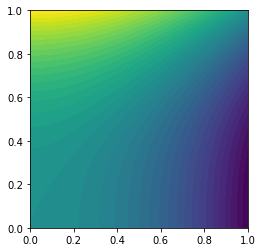

In [13]:
plot(h)

In [26]:
# exact solutions

In [27]:
# f = x^2 * y^2 + x * y
f_exact = Expression("pow(x[0], 2) * pow(x[1], 2) + x[0] * x[1]", degree=4)

# g = x^3 + y^2
g_exact = Expression("pow(x[0], 3) + pow(x[1], 2)", degree=3)

# h = -x^2 + y^3
h_exact = Expression("-pow(x[0], 2) + pow(x[1], 3)", degree=3)

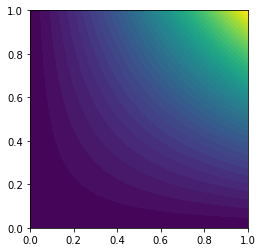

In [28]:
plot(f_exact, mesh = mesh)

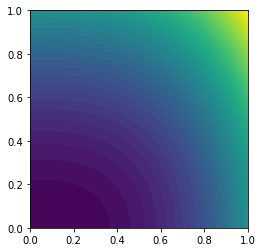

In [29]:
plot(g_exact, mesh = mesh)

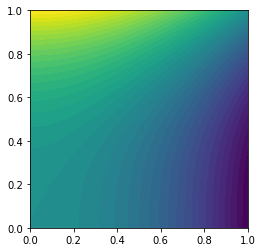

In [30]:
plot(h_exact, mesh = mesh)

In [19]:
vertex_values_f_exact = f_exact.compute_vertex_values(mesh)
vertex_values_g_exact = g_exact.compute_vertex_values(mesh)
vertex_values_f = f.compute_vertex_values(mesh)
vertex_values_g = g.compute_vertex_values(mesh)

error_max_f = np.max(np.abs(vertex_values_f_exact - vertex_values_f))
print("error_max =", error_max_f)
error_max_g = np.max(np.abs(vertex_values_g_exact - vertex_values_g))
print("error_max =", error_max_g)

AttributeError: 'Indexed' object has no attribute 'compute_vertex_values'